In [1]:
from flu_matrix_completion import *
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('scikit-learn version >=1.3.1 is needed as it contains a version of sklearn.tree.DecisionTreeRegressor which is needed for this matrix completion model (this version can handle NAN values in training data).')

The scikit-learn version is 1.3.1.
scikit-learn version >=1.3.1 is needed as it contains a version of sklearn.tree.DecisionTreeRegressor which is needed for this matrix completion model (this version can handle NAN values in training data).


<Axes: ylabel='sampleID'>

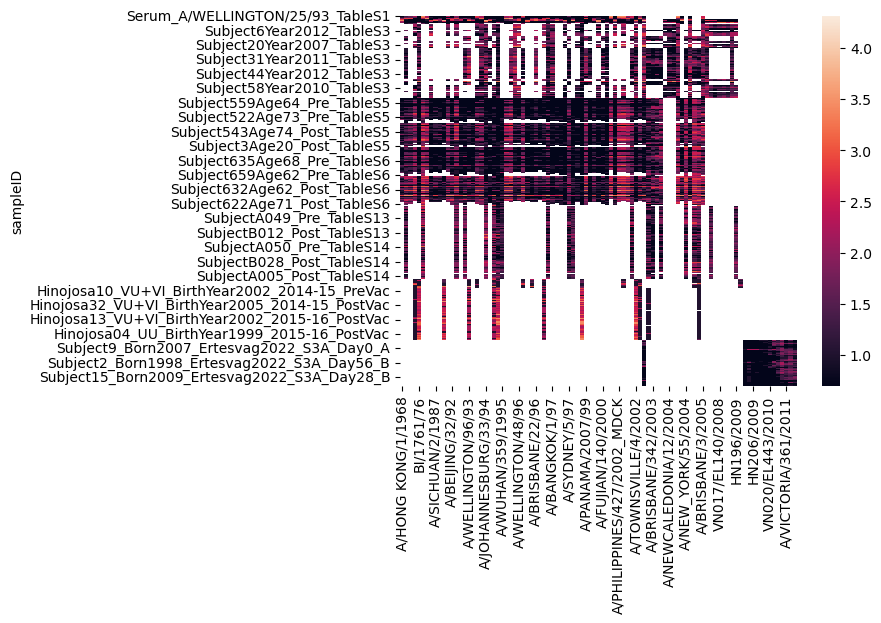

In [2]:
# Load in antisera-virus data as pd.DataFrames
all_HI_df = pd.read_csv("data/all_data.csv", index_col='sampleID')
all_antisera_df = pd.read_csv("data/all_data_antisera_table.csv", index_col='sampleID')
all_HI_data_tables  = HI_data_tables() # Create HI_data_tables object
all_HI_data_tables.add_HI_data(HI_df=all_HI_df,
                               antisera_df=all_antisera_df) # Add data from Tal's ad Rong's original paper
all_HI_data_tables.compute_virus_dates()
sns.heatmap(all_HI_data_tables.HI_data)

# Grid Search Analysis on Matrix Completion Model
Find which hypereparameters can be tuned to improve the performance of matrix completion between two datasets with low transferability

## General Schema of Grid Search


In [5]:
np.random.seed(10) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS1', 'TableS5', 'TableS6', 'TableS13', 'TableS14', 'fon_children', 'fon_ferrets', 'hin_vu14vi15', 'hin_vu15vi16', 'hin_u15u16',  ] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [5, 10, 15, 20, 25] # Number of overlapping viruses to train on 
train_trees_options = [10, 50, 100, 500, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results.csv")

ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_10_best_trees_1, RMSE: 0.8521655217106443
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_10_best_trees_3, RMSE: 0.8237802950972875
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_10_best_trees_5, RMSE: 0.8038993634755062
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_10_best_trees_8, RMSE: 0.7990571476048189
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_10_best_trees_10, RMSE: 0.8031289756050862

ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_50_best_trees_1, RMSE: 0.9546953946346208
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_50_best_trees_3, RMSE: 0.9399125931366534
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS1_n_features_5_train_trees_50_best_trees_5, RMSE: 0.9261294

ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_8, RMSE: 0.6771598323923425
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_10, RMSE: 0.6796106750956087
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_20, RMSE: 0.681964470096718
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_50, RMSE: 0.6784589869651404
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_100, RMSE: 0.6782792764414668
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_200, RMSE: 0.680207070420198
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_trees_300, RMSE: 0.679685845454446
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS1_n_features_10_train_trees_500_best_tree

ensemble no. 16, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_10_best_trees_5, RMSE: 0.5498913189056656
ensemble no. 16, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_10_best_trees_8, RMSE: 0.5423190393515362
ensemble no. 16, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_10_best_trees_10, RMSE: 0.5419057620439396

ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_50_best_trees_1, RMSE: 0.5521732043900103
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_50_best_trees_3, RMSE: 0.5414416579982066
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_50_best_trees_5, RMSE: 0.5435549574143176
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_50_best_trees_8, RMSE: 0.5376436945899445
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS1_n_features_20_train_trees_50_best_trees_10

ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_8, RMSE: 0.5835122401239825
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_10, RMSE: 0.5854656251747815
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_20, RMSE: 0.583803805017808
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_50, RMSE: 0.5827152781485904
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_100, RMSE: 0.5871682786240044
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_200, RMSE: 0.5889120494316352
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500_best_trees_300, RMSE: 0.5911104059155349
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS1_n_features_25_train_trees_500

ensemble no. 31, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_10_best_trees_5, RMSE: 0.33149535865600993
ensemble no. 31, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_10_best_trees_8, RMSE: 0.32206806627855744
ensemble no. 31, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_10_best_trees_10, RMSE: 0.3178812155663312

ensemble no. 32, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_50_best_trees_1, RMSE: 0.426969795275661
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_50_best_trees_3, RMSE: 0.39169758252624076
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_50_best_trees_5, RMSE: 0.37743731499682054
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_50_best_trees_8, RMSE: 0.366585832730113
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS5_n_features_10_train_trees_50_best_trees_

ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_5, RMSE: 0.29525833925821526
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_8, RMSE: 0.2934023525013384
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_10, RMSE: 0.2918958874752039
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_20, RMSE: 0.27727308969935605
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_50, RMSE: 0.27367265203123076
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_100, RMSE: 0.2664571110347584
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_500_best_trees_200, RMSE: 0.2668150237947257
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS5_n_features_15_train_trees_5

ensemble no. 45, full_comparison_name: TableS3.2_to_TableS5_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.30641605410386435

ensemble no. 46, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_10_best_trees_1, RMSE: 0.24531267973681609
ensemble no. 46, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_10_best_trees_3, RMSE: 0.23136150793881569
ensemble no. 46, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_10_best_trees_5, RMSE: 0.226321733714362
ensemble no. 46, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_10_best_trees_8, RMSE: 0.22918447152577548
ensemble no. 46, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_10_best_trees_10, RMSE: 0.22632379876303005

ensemble no. 47, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_50_best_trees_1, RMSE: 0.2246414679354513
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS5_n_features_25_train_trees_50_best

ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_1, RMSE: 0.4544562027672008
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_3, RMSE: 0.4323624215526932
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_5, RMSE: 0.42878185448708445
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_8, RMSE: 0.4224918717567174
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_10, RMSE: 0.41569645864669924
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_20, RMSE: 0.416497372551374
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees_50, RMSE: 0.41370886592648365
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS6_n_features_5_train_trees_500_best_trees

ensemble no. 60, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_1000_best_trees_500, RMSE: 0.2537440569365279
ensemble no. 60, full_comparison_name: TableS3.2_to_TableS6_n_features_10_train_trees_1000_best_trees_750, RMSE: 0.25307972209112917

ensemble no. 61, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_1, RMSE: 0.2714380943099593
ensemble no. 61, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_3, RMSE: 0.24401458456851446
ensemble no. 61, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_5, RMSE: 0.2386089799447832
ensemble no. 61, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_8, RMSE: 0.22761745220038387
ensemble no. 61, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_10_best_trees_10, RMSE: 0.2291010279302748

ensemble no. 62, full_comparison_name: TableS3.2_to_TableS6_n_features_15_train_trees_50_b

ensemble no. 68, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_100_best_trees_50, RMSE: 0.23034306203397886
ensemble no. 68, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_100_best_trees_100, RMSE: 0.2324960001908438

ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_1, RMSE: 0.3106152014053718
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_3, RMSE: 0.28416154222366713
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_5, RMSE: 0.26434457930622457
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_8, RMSE: 0.25450209110111555
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_500_best_trees_10, RMSE: 0.25039094672731005
ensemble no. 69, full_comparison_name: TableS3.2_to_TableS6_n_features_20_train_trees_5

ensemble no. 75, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_1000_best_trees_100, RMSE: 0.21640794196354118
ensemble no. 75, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_1000_best_trees_200, RMSE: 0.21818410089126755
ensemble no. 75, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_1000_best_trees_300, RMSE: 0.21858550931521753
ensemble no. 75, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_1000_best_trees_500, RMSE: 0.2191716997123792
ensemble no. 75, full_comparison_name: TableS3.2_to_TableS6_n_features_25_train_trees_1000_best_trees_750, RMSE: 0.22136032493544971

ensemble no. 76, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_10_best_trees_1, RMSE: 0.24162716829608633
ensemble no. 76, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_10_best_trees_3, RMSE: 0.22443063051600515
ensemble no. 76, full_comparison_name: TableS3.2_to_TableS13_n_features_5_tra

ensemble no. 83, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_100_best_trees_10, RMSE: 0.14600416030687058
ensemble no. 83, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_100_best_trees_20, RMSE: 0.1456762369296324
ensemble no. 83, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_100_best_trees_50, RMSE: 0.14917327280371676
ensemble no. 83, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_100_best_trees_100, RMSE: 0.1536452724615016

ensemble no. 84, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_500_best_trees_1, RMSE: 0.07740882328993913
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_500_best_trees_3, RMSE: 0.07228597065270767
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train_trees_500_best_trees_5, RMSE: 0.0692903190231575
ensemble no. 84, full_comparison_name: TableS3.2_to_TableS13_n_features_10_train

ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_20, RMSE: 0.06520287399346632
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_50, RMSE: 0.06676967899141786
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_100, RMSE: 0.06748171743410798
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_200, RMSE: 0.07053742260299384
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_300, RMSE: 0.0730108748836381
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_500, RMSE: 0.07812158688574891
ensemble no. 90, full_comparison_name: TableS3.2_to_TableS13_n_features_15_train_trees_1000_best_trees_750, RMSE: 0.082131789305988

ensemble no. 91, full_comparison_name: TableS3.2_to_TableS13_n_fea

ensemble no. 98, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_100_best_trees_10, RMSE: 0.0570030894613436
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_100_best_trees_20, RMSE: 0.06339435328363564
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_100_best_trees_50, RMSE: 0.0768646773881348
ensemble no. 98, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_100_best_trees_100, RMSE: 0.08912483881037056

ensemble no. 99, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_500_best_trees_1, RMSE: 0.18400875239578535
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_500_best_trees_3, RMSE: 0.1796216923521103
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train_trees_500_best_trees_5, RMSE: 0.16492006954325814
ensemble no. 99, full_comparison_name: TableS3.2_to_TableS13_n_features_25_train

ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_20, RMSE: 0.3833238363997873
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_50, RMSE: 0.38299644156735907
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_100, RMSE: 0.3844252308484061
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_200, RMSE: 0.38548824753848127
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_300, RMSE: 0.3866091468468569
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_500, RMSE: 0.38738316316932303
ensemble no. 105, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_1000_best_trees_750, RMSE: 0.38762085953526165

ensemble no. 106, full_comparison_name: TableS3.2_to_TableS14_n_fe

ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_1, RMSE: 0.06674395842887182
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_3, RMSE: 0.06292296452550049
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_5, RMSE: 0.06453050407965877
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_8, RMSE: 0.0627513910442359
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_10, RMSE: 0.06148611225055603
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_20, RMSE: 0.06384237711441816
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_15_train_trees_100_best_trees_50, RMSE: 0.06814699026196067
ensemble no. 113, full_comparison_name: TableS3.2_to_TableS14_n_features_1

ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_1, RMSE: 0.16814836059868313
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_3, RMSE: 0.1483197826738585
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_5, RMSE: 0.14041633544667997
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_8, RMSE: 0.1354350646884003
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_10, RMSE: 0.13636691264804987
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_20, RMSE: 0.137019013201734
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_features_20_train_trees_1000_best_trees_50, RMSE: 0.1356996036805222
ensemble no. 120, full_comparison_name: TableS3.2_to_TableS14_n_feature

ensemble no. 127, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_50_best_trees_20, RMSE: 0.3629976468751357
ensemble no. 127, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_50_best_trees_50, RMSE: 0.3591231192056957

ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_1, RMSE: 0.5025564744748149
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_3, RMSE: 0.43549623904283064
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_5, RMSE: 0.44869699365839394
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_8, RMSE: 0.44623159582209815
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_100_best_trees_10, RMSE: 0.4443799322311397
ensemble no. 128, full_comparison_name: TableS3.2_to_fon_

ensemble no. 134, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_500_best_trees_200, RMSE: 0.35652352095887835
ensemble no. 134, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_500_best_trees_300, RMSE: 0.3544219802293417
ensemble no. 134, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_500_best_trees_500, RMSE: 0.3532732080180788

ensemble no. 135, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.3703683132955784
ensemble no. 135, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.3951602598809022
ensemble no. 135, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.3765979076194096
ensemble no. 135, full_comparison_name: TableS3.2_to_fon_children_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.36199146026083195
ensemble no. 135, full_comparison_name: Ta

ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_1, RMSE: 0.18177738640473834
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_3, RMSE: 0.186070605175717
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_5, RMSE: 0.18875124146210212
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_8, RMSE: 0.1836471531457716
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_10, RMSE: 0.18103653979796644
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_20, RMSE: 0.18302471331860432
ensemble no. 142, full_comparison_name: TableS3.2_to_fon_children_n_features_20_train_trees_50_best_trees_50, RMSE: 0.1920411353914253

ensemble no. 143, full_comparison_name: TableS3.2_to_fo

ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_20, RMSE: 0.21675087852098765
ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_50, RMSE: 0.223341140771254
ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_100, RMSE: 0.23072517162158193
ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_200, RMSE: 0.23179817841075248
ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_300, RMSE: 0.2356074882008136
ensemble no. 149, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_500_best_trees_500, RMSE: 0.2407284717333536

ensemble no. 150, full_comparison_name: TableS3.2_to_fon_children_n_features_25_train_trees_1000_best_trees_1, RMSE: 0.2958798523582917
ensemble no. 150, full_comparison_name: T

ensemble no. 156, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_10_best_trees_1, RMSE: 0.4503884020628222
ensemble no. 156, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_10_best_trees_3, RMSE: 0.44478990996458123
ensemble no. 156, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_10_best_trees_5, RMSE: 0.4495416730893619
ensemble no. 156, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_10_best_trees_8, RMSE: 0.45423715764525224
ensemble no. 156, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_10_best_trees_10, RMSE: 0.459133222321022

ensemble no. 157, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_50_best_trees_1, RMSE: 0.6235457720241387
ensemble no. 157, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_10_train_trees_50_best_trees_3, RMSE: 0.6066782839860875
ensemble no. 157, full_comparison_name: TableS3.2_to_fon_ferrets_n

ensemble no. 163, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_100_best_trees_50, RMSE: 0.459059105270021
ensemble no. 163, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_100_best_trees_100, RMSE: 0.4670899905994393

ensemble no. 164, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_500_best_trees_1, RMSE: 0.37630652740226755
ensemble no. 164, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_500_best_trees_3, RMSE: 0.4136595823645212
ensemble no. 164, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_500_best_trees_5, RMSE: 0.40277198562093225
ensemble no. 164, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_500_best_trees_8, RMSE: 0.3926653704979717
ensemble no. 164, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_15_train_trees_500_best_trees_10, RMSE: 0.38805416149432337
ensemble no. 164, full_comparison_name: TableS3.2_to_fo

ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_20, RMSE: 0.4053495103125019
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_50, RMSE: 0.40651416235052573
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_100, RMSE: 0.40559707860268873
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_200, RMSE: 0.40765147067564406
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_300, RMSE: 0.4104008622017229
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_500, RMSE: 0.4146997591632334
ensemble no. 170, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.41978444377291657

ensemble no. 171, full_comparison_name

ensemble no. 177, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_50_best_trees_50, RMSE: 0.3947260337736002

ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_1, RMSE: 0.4431321972343244
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_3, RMSE: 0.4221801840169148
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_5, RMSE: 0.42102343157446165
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_8, RMSE: 0.4253668645347816
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_10, RMSE: 0.4379869010948773
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_100_best_trees_20, RMSE: 0.4329300672575844
ensemble no. 178, full_comparison_name: TableS3.2_to_hin_v

ensemble no. 184, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_500_best_trees_300, RMSE: 0.23479616652946272
ensemble no. 184, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_500_best_trees_500, RMSE: 0.25514391246092166

ensemble no. 185, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.3300772258458406
ensemble no. 185, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.2882995562345159
ensemble no. 185, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.23487985443138523
ensemble no. 185, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.22474079863400032
ensemble no. 185, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_10, RMSE: 0.2100917778627561
ensemble no. 185, full_comparison_name: 

ensemble no. 191, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_10_best_trees_10, RMSE: 0.2418247081602446

ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_1, RMSE: 0.15758971835199015
ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_3, RMSE: 0.1478149098505147
ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_5, RMSE: 0.14817767452955144
ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_8, RMSE: 0.14506071340678545
ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_10, RMSE: 0.14493140861517015
ensemble no. 192, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_20_train_trees_50_best_trees_20, RMSE: 0.15320868764536155
ensemble no. 192, full_comparison_name: TableS3.2_to_

ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_20, RMSE: 0.17229397592870083
ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_50, RMSE: 0.1719946310060246
ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_100, RMSE: 0.18237782549564524
ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_200, RMSE: 0.1985120689513875
ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_300, RMSE: 0.21394165208300692
ensemble no. 199, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_500_best_trees_500, RMSE: 0.23705010541250876

ensemble no. 200, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_25_train_trees_1000_best_trees_1, RMSE: 0.22144307591303494
ensemble no. 200, full_comparison_name

ensemble no. 206, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_1, RMSE: 0.25464114333047827
ensemble no. 206, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_3, RMSE: 0.2826377532572026
ensemble no. 206, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_5, RMSE: 0.30201130592128084
ensemble no. 206, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_8, RMSE: 0.32593858908437356
ensemble no. 206, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_10, RMSE: 0.3359898858331427

ensemble no. 207, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_50_best_trees_1, RMSE: 0.17473333243537217
ensemble no. 207, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_50_best_trees_3, RMSE: 0.1472436433028388
ensemble no. 207, full_comparison_name: TableS3.2_to_hin

ensemble no. 213, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_100_best_trees_50, RMSE: 0.3078553283118365
ensemble no. 213, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_100_best_trees_100, RMSE: 0.3302592675691254

ensemble no. 214, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_500_best_trees_1, RMSE: 0.24187122137238298
ensemble no. 214, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_500_best_trees_3, RMSE: 0.22892087855158677
ensemble no. 214, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_500_best_trees_5, RMSE: 0.21985145734195505
ensemble no. 214, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_500_best_trees_8, RMSE: 0.22505734861371113
ensemble no. 214, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_15_train_trees_500_best_trees_10, RMSE: 0.22414647417249814
ensemble no. 214, full_comparison_name: Table

ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_50, RMSE: 0.2509214897935897
ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_100, RMSE: 0.2538944911942195
ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_200, RMSE: 0.2631701043089439
ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_300, RMSE: 0.2696076628773572
ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_500, RMSE: 0.2785918398830395
ensemble no. 220, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.2895451155299817

ensemble no. 221, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_25_train_trees_10_best_trees_1, RMSE: 0.2813048279319529
ensemble no. 221, full_comparison_name

ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_1, RMSE: 0.7355397967984378
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_3, RMSE: 0.6698137587727836
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_5, RMSE: 0.649692168924988
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_8, RMSE: 0.6216862770819473
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_10, RMSE: 0.6143656178209584
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_20, RMSE: 0.6213395351410171
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_100_best_trees_50, RMSE: 0.6241608414855918
ensemble no. 228, full_comparison_name: TableS3.2_to_hin_u15u16_n_features

ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.3375192944610018
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.29431554131456233
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.2897489873212907
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.28969996436279166
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_10, RMSE: 0.2857226728584223
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_20, RMSE: 0.2800736476518353
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_50, RMSE: 0.2821229304196014
ensemble no. 235, full_comparison_name: TableS3.2_to_hin_

ensemble no. 242, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_50_best_trees_20, RMSE: 0.23092270344470017
ensemble no. 242, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_50_best_trees_50, RMSE: 0.26094162511783464

ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_100_best_trees_1, RMSE: 0.3610048570073658
ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_100_best_trees_3, RMSE: 0.36873795692634537
ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_100_best_trees_5, RMSE: 0.37071111690023445
ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_100_best_trees_8, RMSE: 0.36416817162029586
ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_20_train_trees_100_best_trees_10, RMSE: 0.37515898966418076
ensemble no. 243, full_comparison_name: TableS3.2_to_hin_u15u

ensemble no. 249, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_500_best_trees_200, RMSE: 0.23813803312781556
ensemble no. 249, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_500_best_trees_300, RMSE: 0.2503920662189342
ensemble no. 249, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_500_best_trees_500, RMSE: 0.27271301242192514

ensemble no. 250, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_1000_best_trees_1, RMSE: 0.22068791214167557
ensemble no. 250, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_1000_best_trees_3, RMSE: 0.1975398777110131
ensemble no. 250, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_1000_best_trees_5, RMSE: 0.20300808312050322
ensemble no. 250, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_25_train_trees_1000_best_trees_8, RMSE: 0.1996435850187488
ensemble no. 250, full_comparison_name: TableS3.2_to_h

ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_1, RMSE: 0.6955716127271346
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_3, RMSE: 0.6751918332237756
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_5, RMSE: 0.6612128487704104
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_8, RMSE: 0.6550666359202914
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_10, RMSE: 0.6484544557779397
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_20, RMSE: 0.6440211995389539
ensemble no. 257, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_50_best_trees_50, RMSE: 0.635660647143464

ensemble no. 258, full_comparison_name: TableS3.1_to_TableS1_n_features_10_train_trees_100_bes

ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_20, RMSE: 0.5534024414136383
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_50, RMSE: 0.5516840887852752
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_100, RMSE: 0.5552391783733439
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_200, RMSE: 0.5553957419680777
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_300, RMSE: 0.5550581937699192
ensemble no. 264, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_500_best_trees_500, RMSE: 0.5582492476592965

ensemble no. 265, full_comparison_name: TableS3.1_to_TableS1_n_features_15_train_trees_1000_best_trees_1, RMSE: 0.6637186469791707
ensemble no. 265, full_comparison_name: TableS3.1_to_TableS1_n_features_15_tra

ensemble no. 271, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_10_best_trees_8, RMSE: 0.4738785320898641
ensemble no. 271, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_10_best_trees_10, RMSE: 0.47622994108626304

ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_best_trees_1, RMSE: 0.513502843497208
ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_best_trees_3, RMSE: 0.49969952799082773
ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_best_trees_5, RMSE: 0.4913378813999448
ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_best_trees_8, RMSE: 0.4909116369589037
ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_best_trees_10, RMSE: 0.4947338501610936
ensemble no. 272, full_comparison_name: TableS3.1_to_TableS1_n_features_25_train_trees_50_bes

ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_8, RMSE: 0.4769641694863573
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_10, RMSE: 0.47651776145855895
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_20, RMSE: 0.47600545175754005
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_50, RMSE: 0.4751613518832795
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_100, RMSE: 0.47303015234278933
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_200, RMSE: 0.47258568205145807
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_trees_500_best_trees_300, RMSE: 0.4735562452798525
ensemble no. 279, full_comparison_name: TableS3.1_to_TableS5_n_features_5_train_tree

ensemble no. 286, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_10_best_trees_1, RMSE: 0.4786462233243118
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_10_best_trees_3, RMSE: 0.4109438846423521
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_10_best_trees_5, RMSE: 0.4077727664618752
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_10_best_trees_8, RMSE: 0.40274431720905896
ensemble no. 286, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_10_best_trees_10, RMSE: 0.40728364945103523

ensemble no. 287, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_50_best_trees_1, RMSE: 0.37164924103156083
ensemble no. 287, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_50_best_trees_3, RMSE: 0.36384260077950614
ensemble no. 287, full_comparison_name: TableS3.1_to_TableS5_n_features_15_train_trees_50_b

ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_1, RMSE: 0.3911957893492672
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_3, RMSE: 0.36641987930147046
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_5, RMSE: 0.356665193245395
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_8, RMSE: 0.35073455181705465
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_10, RMSE: 0.3491980913127382
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_20, RMSE: 0.35094793210446273
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_trees_500_best_trees_50, RMSE: 0.3479149588791482
ensemble no. 294, full_comparison_name: TableS3.1_to_TableS5_n_features_20_train_tree

ensemble no. 300, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_300, RMSE: 0.32170524629111047
ensemble no. 300, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_500, RMSE: 0.32528594403540817
ensemble no. 300, full_comparison_name: TableS3.1_to_TableS5_n_features_25_train_trees_1000_best_trees_750, RMSE: 0.3285623913709571

ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_10_best_trees_1, RMSE: 0.5684078969616316
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_10_best_trees_3, RMSE: 0.516797077977909
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_10_best_trees_5, RMSE: 0.5171375909563457
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_10_best_trees_8, RMSE: 0.5107931369151736
ensemble no. 301, full_comparison_name: TableS3.1_to_TableS6_n_features_5_train_trees_1

ensemble no. 308, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_100_best_trees_50, RMSE: 0.4046502976409966
ensemble no. 308, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_100_best_trees_100, RMSE: 0.4028667509779233

ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_500_best_trees_1, RMSE: 0.4810159174083438
ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_500_best_trees_3, RMSE: 0.4204803067180782
ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_500_best_trees_5, RMSE: 0.41462584739067515
ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_500_best_trees_8, RMSE: 0.4088920414408983
ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_trees_500_best_trees_10, RMSE: 0.4047297519502575
ensemble no. 309, full_comparison_name: TableS3.1_to_TableS6_n_features_10_train_tre

ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_100, RMSE: 0.37303512491444313
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_200, RMSE: 0.3738502011459018
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_300, RMSE: 0.37398573667274176
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_500, RMSE: 0.37309375003228384
ensemble no. 315, full_comparison_name: TableS3.1_to_TableS6_n_features_15_train_trees_1000_best_trees_750, RMSE: 0.37278116048458354

ensemble no. 316, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_10_best_trees_1, RMSE: 0.38010903796463674
ensemble no. 316, full_comparison_name: TableS3.1_to_TableS6_n_features_20_train_trees_10_best_trees_3, RMSE: 0.37042247306140536
ensemble no. 316, full_comparison_name: TableS3.1_to_TableS6_n_feature

ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_100_best_trees_8, RMSE: 0.35466856912740063
ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_100_best_trees_10, RMSE: 0.34918584453058676
ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_100_best_trees_20, RMSE: 0.35432544416137585
ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_100_best_trees_50, RMSE: 0.35116305250527047
ensemble no. 323, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_100_best_trees_100, RMSE: 0.3527523522617202

ensemble no. 324, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_1, RMSE: 0.43043596191466893
ensemble no. 324, full_comparison_name: TableS3.1_to_TableS6_n_features_25_train_trees_500_best_trees_3, RMSE: 0.3885568600576277
ensemble no. 324, full_comparison_name: TableS3.1_to_TableS6_n_features_25_trai

ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_10, RMSE: 0.42023467981727264
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_20, RMSE: 0.4153624971448258
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_50, RMSE: 0.4138486573465015
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_100, RMSE: 0.41033275326021146
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_200, RMSE: 0.40870042486409236
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_300, RMSE: 0.40795648022524034
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_1000_best_trees_500, RMSE: 0.4065282110807456
ensemble no. 330, full_comparison_name: TableS3.1_to_TableS13_n_feat

ensemble no. 337, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_50_best_trees_50, RMSE: 0.20130114957227777

ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_1, RMSE: 0.21241046817906364
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_3, RMSE: 0.19764273061240936
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_5, RMSE: 0.18801196374690107
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_8, RMSE: 0.18779337696684895
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_10, RMSE: 0.1847008616875485
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15_train_trees_100_best_trees_20, RMSE: 0.1810561636835074
ensemble no. 338, full_comparison_name: TableS3.1_to_TableS13_n_features_15

ensemble no. 344, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_500_best_trees_500, RMSE: 0.22123084087107095

ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_1, RMSE: 0.32086069567790915
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_3, RMSE: 0.26360787164179256
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_5, RMSE: 0.2581251885918964
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_8, RMSE: 0.2583353049546838
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_10, RMSE: 0.25760919026619117
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_features_20_train_trees_1000_best_trees_20, RMSE: 0.2551276459178244
ensemble no. 345, full_comparison_name: TableS3.1_to_TableS13_n_feat

ensemble no. 352, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_50_best_trees_8, RMSE: 0.46826515711346944
ensemble no. 352, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_50_best_trees_10, RMSE: 0.4679369099946518
ensemble no. 352, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_50_best_trees_20, RMSE: 0.4649236489850905
ensemble no. 352, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_50_best_trees_50, RMSE: 0.4645736655696653

ensemble no. 353, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_1, RMSE: 0.4398690549812229
ensemble no. 353, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_3, RMSE: 0.4115692273231733
ensemble no. 353, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_100_best_trees_5, RMSE: 0.40814656870659693
ensemble no. 353, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_1

ensemble no. 359, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_500_best_trees_200, RMSE: 0.3079459199744763
ensemble no. 359, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_500_best_trees_300, RMSE: 0.3084845426785823
ensemble no. 359, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_500_best_trees_500, RMSE: 0.3103152290465906

ensemble no. 360, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.37693750014957467
ensemble no. 360, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.3442469050357457
ensemble no. 360, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.33322339765881476
ensemble no. 360, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.32848621412998097
ensemble no. 360, full_comparison_name: TableS3.1_to_TableS14_n_featu

ensemble no. 366, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_10_best_trees_10, RMSE: 0.1822602146177652

ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_1, RMSE: 0.3365958968769384
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_3, RMSE: 0.2760447000746958
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_5, RMSE: 0.27229957418386264
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_8, RMSE: 0.26186412652438107
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_10, RMSE: 0.25593014325316227
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_trees_50_best_trees_20, RMSE: 0.24855528654714637
ensemble no. 367, full_comparison_name: TableS3.1_to_TableS14_n_features_20_train_

ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_8, RMSE: 0.2226853211529253
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_10, RMSE: 0.2196772081118894
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_20, RMSE: 0.21352259581899452
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_50, RMSE: 0.21006398424188968
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_100, RMSE: 0.20793198983732128
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_200, RMSE: 0.21014701187752152
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_features_25_train_trees_500_best_trees_300, RMSE: 0.21200893916851385
ensemble no. 374, full_comparison_name: TableS3.1_to_TableS14_n_featu

ensemble no. 380, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_1000_best_trees_500, RMSE: 0.3558846411522776
ensemble no. 380, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_1000_best_trees_750, RMSE: 0.3562014391308334

ensemble no. 381, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_10_best_trees_1, RMSE: 0.2095738466285682
ensemble no. 381, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_10_best_trees_3, RMSE: 0.1967370092623493
ensemble no. 381, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_10_best_trees_5, RMSE: 0.18636654064434838
ensemble no. 381, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_10_best_trees_8, RMSE: 0.19505996546718204
ensemble no. 381, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_10_best_trees_10, RMSE: 0.2005901480218054

ensemble no. 382, full_comparison_name: TableS3.1_t

ensemble no. 388, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_100_best_trees_20, RMSE: 0.19695405567946225
ensemble no. 388, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_100_best_trees_50, RMSE: 0.19811513434803707
ensemble no. 388, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_100_best_trees_100, RMSE: 0.20437412120203605

ensemble no. 389, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_500_best_trees_1, RMSE: 0.13607607442940298
ensemble no. 389, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_500_best_trees_3, RMSE: 0.12028353963034275
ensemble no. 389, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_500_best_trees_5, RMSE: 0.11890414597842093
ensemble no. 389, full_comparison_name: TableS3.1_to_fon_children_n_features_15_train_trees_500_best_trees_8, RMSE: 0.1185748117753757
ensemble no. 389, full_comparison_name: Tabl

ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_20, RMSE: 0.16070991815084554
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_50, RMSE: 0.1531752121832549
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_100, RMSE: 0.14968389085100395
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_200, RMSE: 0.15352845651331407
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_300, RMSE: 0.15242966422812168
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_500, RMSE: 0.1531328254017242
ensemble no. 395, full_comparison_name: TableS3.1_to_fon_children_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.15168023441826187

ensemble no. 396, full_compari

ensemble no. 402, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_50_best_trees_50, RMSE: 0.5192357220266349

ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_1, RMSE: 0.7568189630363792
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_3, RMSE: 0.7130715043480498
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_5, RMSE: 0.7204428838345884
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_8, RMSE: 0.7126885022476772
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_10, RMSE: 0.7129364945219729
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_100_best_trees_20, RMSE: 0.7050699385680748
ensemble no. 403, full_comparison_name: TableS3.1_to_fon_ferrets_n

ensemble no. 409, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_300, RMSE: 0.4538429544086882
ensemble no. 409, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_500, RMSE: 0.4557777810989799

ensemble no. 410, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.5109192429164003
ensemble no. 410, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.45609276177753366
ensemble no. 410, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.4616398903990572
ensemble no. 410, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.4596173257707563
ensemble no. 410, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_1000_best_trees_10, RMSE: 0.46820344809049824
ensemble no. 410, full_comparison_name: TableS3.1

ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_1, RMSE: 0.3022055283772088
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_3, RMSE: 0.30344147517851194
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_5, RMSE: 0.3031618107037106
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_8, RMSE: 0.3040668682728249
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_10, RMSE: 0.30519855073041613
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_20, RMSE: 0.3132410274680826
ensemble no. 417, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_20_train_trees_50_best_trees_50, RMSE: 0.33067868190627125

ensemble no. 418, full_comparison_name: TableS3.1_to_fon_ferre

ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_20, RMSE: 0.3380054747329875
ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_50, RMSE: 0.33722803761384507
ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_100, RMSE: 0.33849953346685957
ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_200, RMSE: 0.3458756333516828
ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_300, RMSE: 0.35150548427488276
ensemble no. 424, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_500_best_trees_500, RMSE: 0.3600668875391916

ensemble no. 425, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_25_train_trees_1000_best_trees_1, RMSE: 0.27882365662829867
ensemble no. 425, full_comparison_name: TableS

ensemble no. 431, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_10_best_trees_1, RMSE: 0.34141098677944276
ensemble no. 431, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_10_best_trees_3, RMSE: 0.29010008718172636
ensemble no. 431, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_10_best_trees_5, RMSE: 0.29144660564653824
ensemble no. 431, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_10_best_trees_8, RMSE: 0.31188151610614734
ensemble no. 431, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_10_best_trees_10, RMSE: 0.31892864199769166

ensemble no. 432, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_50_best_trees_1, RMSE: 0.4687312919243263
ensemble no. 432, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_50_best_trees_3, RMSE: 0.5208465941086236
ensemble no. 432, full_comparison_name: TableS3.1_to_hi

ensemble no. 438, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_100_best_trees_50, RMSE: 0.3069013488611288
ensemble no. 438, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_100_best_trees_100, RMSE: 0.3350648872927628

ensemble no. 439, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_500_best_trees_1, RMSE: 0.3435291248562872
ensemble no. 439, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_500_best_trees_3, RMSE: 0.37272454508051733
ensemble no. 439, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_500_best_trees_5, RMSE: 0.34347073645740533
ensemble no. 439, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_500_best_trees_8, RMSE: 0.3441190392921321
ensemble no. 439, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_15_train_trees_500_best_trees_10, RMSE: 0.3548428124432737
ensemble no. 439, full_comparison_name: TableS3.

ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_50, RMSE: 0.22751383154611227
ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_100, RMSE: 0.23495809390501057
ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_200, RMSE: 0.23608123670215922
ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_300, RMSE: 0.2389600461025958
ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_500, RMSE: 0.2456758324198217
ensemble no. 445, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_20_train_trees_1000_best_trees_750, RMSE: 0.26055752355247186

ensemble no. 446, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_25_train_trees_10_best_trees_1, RMSE: 0.2811156126240728
ensemble no. 446, full_comparison_

ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_1, RMSE: 0.39581045399889575
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_3, RMSE: 0.3855489567743916
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_5, RMSE: 0.3893822346860691
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_8, RMSE: 0.3748041673015294
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_10, RMSE: 0.36768802283594576
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_20, RMSE: 0.37266343756152787
ensemble no. 453, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_50, RMSE: 0.3948983853118376
ensemble no. 453, full_comparison_name: TableS3.1_to_hin

ensemble no. 459, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_500, RMSE: 0.36606328470001914

ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.5044618288050481
ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_3, RMSE: 0.38180223817960984
ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_5, RMSE: 0.40504841193010355
ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_8, RMSE: 0.3866955626507909
ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_10, RMSE: 0.4273902470111155
ensemble no. 460, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_20, RMSE: 0.4299602110754534
ensemble no. 460, full_comparison_name: T

ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_1, RMSE: 0.33758318048797276
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_3, RMSE: 0.34256048248543375
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_5, RMSE: 0.3455915521176478
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_8, RMSE: 0.3517427437668735
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_10, RMSE: 0.35368405957763094
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_20, RMSE: 0.35991751312458437
ensemble no. 467, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_20_train_trees_50_best_trees_50, RMSE: 0.3882809478174722

ensemble no. 468, full_comparison_name: TableS3.1_to_h

ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_20, RMSE: 0.3394652991643372
ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_50, RMSE: 0.35244815195381907
ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_100, RMSE: 0.36229202743594197
ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_200, RMSE: 0.3752824679717323
ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_300, RMSE: 0.38285411119310353
ensemble no. 474, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_500_best_trees_500, RMSE: 0.3954624043567869

ensemble no. 475, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_25_train_trees_1000_best_trees_1, RMSE: 0.265751649254075
ensemble no. 475, full_comparison_name: T

ensemble no. 481, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_10_best_trees_10, RMSE: 0.48003110959332485

ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_1, RMSE: 0.5989613347134699
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_3, RMSE: 0.5376439353625745
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_5, RMSE: 0.5262239658989797
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_8, RMSE: 0.5172153708892288
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_10, RMSE: 0.5156505477369043
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_50_best_trees_20, RMSE: 0.5262273904497308
ensemble no. 482, full_comparison_name: TableS3.1_to_hin_u15u16_n_featu

ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_20, RMSE: 0.2371400087825003
ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_50, RMSE: 0.23657005275563686
ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_100, RMSE: 0.23867991642112835
ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_200, RMSE: 0.24343797430246342
ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_300, RMSE: 0.25087541804106317
ensemble no. 489, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_500_best_trees_500, RMSE: 0.2638551935613163

ensemble no. 490, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_15_train_trees_1000_best_trees_1, RMSE: 0.2676411687034714
ensemble no. 490, full_comparison_name: TableS3.1_to_

ensemble no. 496, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_10_best_trees_1, RMSE: 0.33669792638218476
ensemble no. 496, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_10_best_trees_3, RMSE: 0.3279265787152625
ensemble no. 496, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_10_best_trees_5, RMSE: 0.316508347989357
ensemble no. 496, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_10_best_trees_8, RMSE: 0.30849382520297325
ensemble no. 496, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_10_best_trees_10, RMSE: 0.3100067394001996

ensemble no. 497, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_50_best_trees_1, RMSE: 0.3527777596852657
ensemble no. 497, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_25_train_trees_50_best_trees_3, RMSE: 0.33947961046100433
ensemble no. 497, full_comparison_name: TableS3.1_to_hin_u15u16_n_featur

In [ ]:
'''
Must only train trees on viruses in intersection
'''

## Secondary grid search on tables with less viable featuers

In [3]:
np.random.seed(10) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS13', 'TableS14', 'fon_children', 'fon_ferrets', 'hin_vu14vi15', 'hin_vu15vi16', 'hin_u15u16',  ] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [3, 5, 6, 7, 8, 10] # Number of overlapping viruses to train on 
train_trees_options = [10, 50, 100, 500, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info_secondary.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results_secondary.csv")

ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_1, RMSE: 0.3399691167573087
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_3, RMSE: 0.33446202542637926
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_5, RMSE: 0.334715874860159
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_8, RMSE: 0.3345090116559127
ensemble no. 1, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_10_best_trees_10, RMSE: 0.3357574145478757

ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_50_best_trees_1, RMSE: 0.378909423781192
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_50_best_trees_3, RMSE: 0.3843958156427577
ensemble no. 2, full_comparison_name: TableS3.2_to_TableS13_n_features_3_train_trees_50_best_trees_5, RMSE: 0.

ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_10, RMSE: 0.28469849616507303
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_20, RMSE: 0.2821996724599135
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_50, RMSE: 0.27967487296188914
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_100, RMSE: 0.2792394923677183
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_200, RMSE: 0.27866670282437117
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_300, RMSE: 0.2789599205052203
ensemble no. 9, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_500_best_trees_500, RMSE: 0.2818791808085153

ensemble no. 10, full_comparison_name: TableS3.2_to_TableS13_n_features_5_train_trees_100

ensemble no. 16, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_10_best_trees_10, RMSE: 0.21007157654220923

ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_1, RMSE: 0.32140136321748647
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_3, RMSE: 0.30146618905027933
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_5, RMSE: 0.2946022901219666
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_8, RMSE: 0.28763383570217854
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_10, RMSE: 0.2839414466991924
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_trees_20, RMSE: 0.277859717601714
ensemble no. 17, full_comparison_name: TableS3.2_to_TableS13_n_features_7_train_trees_50_best_tre

ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_10, RMSE: 0.07942293289372537
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_20, RMSE: 0.08013669626577562
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_50, RMSE: 0.08062492678971732
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_100, RMSE: 0.08248354906090069
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_200, RMSE: 0.08590221720084315
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_300, RMSE: 0.08838338535490148
ensemble no. 24, full_comparison_name: TableS3.2_to_TableS13_n_features_8_train_trees_500_best_trees_500, RMSE: 0.09457942195936322

ensemble no. 25, full_comparison_name: TableS3.2_to_TableS13_n_features_8_trai

ensemble no. 31, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_10_best_trees_10, RMSE: 0.41993808759578627

ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_1, RMSE: 0.2448832578434759
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_3, RMSE: 0.23315022069418406
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_5, RMSE: 0.23276663199987233
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_8, RMSE: 0.23073684695902497
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_10, RMSE: 0.23201413064617837
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_trees_20, RMSE: 0.23086459281166805
ensemble no. 32, full_comparison_name: TableS3.2_to_TableS14_n_features_3_train_trees_50_best_

ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_10, RMSE: 0.2590476257452541
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_20, RMSE: 0.2596079798915557
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_50, RMSE: 0.25662922746822464
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_100, RMSE: 0.2557150697437162
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_200, RMSE: 0.2569361882302445
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_300, RMSE: 0.25858092991638937
ensemble no. 39, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_trees_500_best_trees_500, RMSE: 0.2606948210940638

ensemble no. 40, full_comparison_name: TableS3.2_to_TableS14_n_features_5_train_tre

ensemble no. 46, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_10_best_trees_10, RMSE: 0.24836861870556246

ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_1, RMSE: 0.3295892473108123
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_3, RMSE: 0.3256252980188083
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_5, RMSE: 0.3070926323873311
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_8, RMSE: 0.3094386937662745
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_10, RMSE: 0.30802745644510904
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_trees_20, RMSE: 0.30093850021955354
ensemble no. 47, full_comparison_name: TableS3.2_to_TableS14_n_features_7_train_trees_50_best_tre

ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_10, RMSE: 0.13616558517346755
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_20, RMSE: 0.13911174770917756
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_50, RMSE: 0.13644616629294698
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_100, RMSE: 0.13741384464659778
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_200, RMSE: 0.1375259842192981
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_300, RMSE: 0.13932594323003808
ensemble no. 54, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train_trees_500_best_trees_500, RMSE: 0.14311169205315352

ensemble no. 55, full_comparison_name: TableS3.2_to_TableS14_n_features_8_train

ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_1, RMSE: 0.5854977683533407
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_3, RMSE: 0.6044776802435297
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_5, RMSE: 0.6046951092723111
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_8, RMSE: 0.6213220510876936
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_10, RMSE: 0.6151500664914229
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_20, RMSE: 0.6175352368374566
ensemble no. 62, full_comparison_name: TableS3.2_to_fon_children_n_features_3_train_trees_50_best_trees_50, RMSE: 0.6003344722995636

ensemble no. 63, full_comparison_name: TableS3.2_to_fon_children_n_featu

ensemble no. 69, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_500_best_trees_50, RMSE: 0.3888749762700233
ensemble no. 69, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_500_best_trees_100, RMSE: 0.388570734292669
ensemble no. 69, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_500_best_trees_200, RMSE: 0.39385563543895086
ensemble no. 69, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_500_best_trees_300, RMSE: 0.39616381332025036
ensemble no. 69, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_500_best_trees_500, RMSE: 0.39818811557385797

ensemble no. 70, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_1000_best_trees_1, RMSE: 0.4794452709194844
ensemble no. 70, full_comparison_name: TableS3.2_to_fon_children_n_features_5_train_trees_1000_best_trees_3, RMSE: 0.46703944790746554
ensemble no. 70, full_comparison_name: TableS3.2_to_fo

ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_1, RMSE: 0.3596531327824585
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_3, RMSE: 0.387718254817956
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_5, RMSE: 0.3790090955608945
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_8, RMSE: 0.37542664641947254
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_10, RMSE: 0.36356374858935336
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_20, RMSE: 0.3569190538416413
ensemble no. 77, full_comparison_name: TableS3.2_to_fon_children_n_features_7_train_trees_50_best_trees_50, RMSE: 0.34770664637129395

ensemble no. 78, full_comparison_name: TableS3.2_to_fon_children_n_fea

ensemble no. 84, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_500_best_trees_50, RMSE: 0.33318365866034744
ensemble no. 84, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_500_best_trees_100, RMSE: 0.33460901419234906
ensemble no. 84, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_500_best_trees_200, RMSE: 0.3361695609651105
ensemble no. 84, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_500_best_trees_300, RMSE: 0.336747066224688
ensemble no. 84, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_500_best_trees_500, RMSE: 0.33692839945307607

ensemble no. 85, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_1000_best_trees_1, RMSE: 0.4884390831269128
ensemble no. 85, full_comparison_name: TableS3.2_to_fon_children_n_features_8_train_trees_1000_best_trees_3, RMSE: 0.444807425714986
ensemble no. 85, full_comparison_name: TableS3.2_to_fon_

ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_1, RMSE: 0.7339917686840688
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_3, RMSE: 0.72399038932763
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_5, RMSE: 0.7252174529987578
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_8, RMSE: 0.7295607579481586
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_10, RMSE: 0.7259699337419179
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_20, RMSE: 0.7316926415099276
ensemble no. 92, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_train_trees_50_best_trees_50, RMSE: 0.7373664077963222

ensemble no. 93, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_3_trai

ensemble no. 99, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_500_best_trees_50, RMSE: 0.5826900803320626
ensemble no. 99, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_500_best_trees_100, RMSE: 0.5848134941726989
ensemble no. 99, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_500_best_trees_200, RMSE: 0.5827222615320524
ensemble no. 99, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_500_best_trees_300, RMSE: 0.5824045171506944
ensemble no. 99, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_500_best_trees_500, RMSE: 0.58221723140958

ensemble no. 100, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_1000_best_trees_1, RMSE: 0.817864148338575
ensemble no. 100, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_5_train_trees_1000_best_trees_3, RMSE: 0.8340402261289295
ensemble no. 100, full_comparison_name: TableS3.2_to_fon_ferrets_

ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_1, RMSE: 0.6068229289912342
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_3, RMSE: 0.6006159424935124
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_5, RMSE: 0.5900248582475949
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_8, RMSE: 0.5937892285120492
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_10, RMSE: 0.5861583765271324
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_20, RMSE: 0.5877291384494573
ensemble no. 107, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_7_train_trees_50_best_trees_50, RMSE: 0.5886168673839615

ensemble no. 108, full_comparison_name: TableS3.2_to_fon_ferrets_n_featu

ensemble no. 114, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_500_best_trees_50, RMSE: 0.5745606617096689
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_500_best_trees_100, RMSE: 0.5729757737039967
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_500_best_trees_200, RMSE: 0.5765192954369461
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_500_best_trees_300, RMSE: 0.5747897094008225
ensemble no. 114, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_500_best_trees_500, RMSE: 0.5771536556708522

ensemble no. 115, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_1000_best_trees_1, RMSE: 0.5631827968163234
ensemble no. 115, full_comparison_name: TableS3.2_to_fon_ferrets_n_features_8_train_trees_1000_best_trees_3, RMSE: 0.5099406089851636
ensemble no. 115, full_comparison_name: TableS3.2_to_fon_

ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_1, RMSE: 0.5227540921221469
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_3, RMSE: 0.5662330982689837
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_5, RMSE: 0.5510864279091159
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_8, RMSE: 0.5570811822770989
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_10, RMSE: 0.5487048165833164
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_20, RMSE: 0.5551180588100748
ensemble no. 122, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_3_train_trees_50_best_trees_50, RMSE: 0.5499876197801585

ensemble no. 123, full_comparison_name: TableS3.2_to_hin_vu14vi15

ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_20, RMSE: 0.4145898717970016
ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_50, RMSE: 0.4075107063172458
ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_100, RMSE: 0.4116002747565417
ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_200, RMSE: 0.4153561526895253
ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_300, RMSE: 0.4192623054903159
ensemble no. 129, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_500_best_trees_500, RMSE: 0.42861249034066223

ensemble no. 130, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_5_train_trees_1000_best_trees_1, RMSE: 0.481197956368227
ensemble no. 130, full_comparison_name: TableS3.2_

ensemble no. 136, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_1, RMSE: 0.18089077881589777
ensemble no. 136, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_3, RMSE: 0.17126477002864757
ensemble no. 136, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_5, RMSE: 0.1740167637428895
ensemble no. 136, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_8, RMSE: 0.18982187140677748
ensemble no. 136, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_10_best_trees_10, RMSE: 0.2009758424901864

ensemble no. 137, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_50_best_trees_1, RMSE: 0.23013831307095986
ensemble no. 137, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_7_train_trees_50_best_trees_3, RMSE: 0.22025730347782677
ensemble no. 137, full_comparison_name: TableS3.2_to_hin_vu14v

ensemble no. 143, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_100_best_trees_100, RMSE: 0.2535608242482536

ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_1, RMSE: 0.28080451596171935
ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_3, RMSE: 0.26991628043748633
ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_5, RMSE: 0.26033186702233585
ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_8, RMSE: 0.25732736524428107
ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_10, RMSE: 0.25574702725898957
ensemble no. 144, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_8_train_trees_500_best_trees_20, RMSE: 0.2619731610622458
ensemble no. 144, full_comparison_name: TableS3.2_to

ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_50, RMSE: 0.28824114712202487
ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_100, RMSE: 0.2845887273315266
ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_200, RMSE: 0.28875610875505475
ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_300, RMSE: 0.29032051331982545
ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_500, RMSE: 0.29526618311948666
ensemble no. 150, full_comparison_name: TableS3.2_to_hin_vu14vi15_n_features_10_train_trees_1000_best_trees_750, RMSE: 0.30019302710691614

ensemble no. 151, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_3_train_trees_10_best_trees_1, RMSE: 0.7677192153389215
ensemble no. 151, full_comparison_

ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_1, RMSE: 0.3351714996607164
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_3, RMSE: 0.3455576434845295
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_5, RMSE: 0.3379178467155256
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_8, RMSE: 0.3318429921792172
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_10, RMSE: 0.3311106132778066
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_20, RMSE: 0.33028143316925923
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_5_train_trees_100_best_trees_50, RMSE: 0.33246673959896816
ensemble no. 158, full_comparison_name: TableS3.2_to_hin_

ensemble no. 164, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_500_best_trees_500, RMSE: 0.4676756583080534

ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_1, RMSE: 0.6025258760753532
ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_3, RMSE: 0.5750135204594925
ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_5, RMSE: 0.5712373647687989
ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_8, RMSE: 0.5681883797863313
ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_10, RMSE: 0.564721022129971
ensemble no. 165, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_6_train_trees_1000_best_trees_20, RMSE: 0.5621319801252485
ensemble no. 165, full_comparison_name: TableS3.2_to

ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_1, RMSE: 0.29986204939899197
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_3, RMSE: 0.28752338409844413
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_5, RMSE: 0.27810088103874936
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_8, RMSE: 0.29352628986604656
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_10, RMSE: 0.2949812875738823
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_20, RMSE: 0.2960221813060882
ensemble no. 172, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_8_train_trees_50_best_trees_50, RMSE: 0.31095350442852704

ensemble no. 173, full_comparison_name: TableS3.2_to_hin_vu1

ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_20, RMSE: 0.5690896394506207
ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_50, RMSE: 0.553423007063196
ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_100, RMSE: 0.5548309202518641
ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_200, RMSE: 0.5638787191772616
ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_300, RMSE: 0.564418727062575
ensemble no. 179, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_500_best_trees_500, RMSE: 0.5580749154862545

ensemble no. 180, full_comparison_name: TableS3.2_to_hin_vu15vi16_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.4493560789600366
ensemble no. 180, full_comparison_name: Table

ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_1, RMSE: 0.4593695186578715
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_3, RMSE: 0.49664051351174177
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_5, RMSE: 0.49306925660797857
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_8, RMSE: 0.5026820868963299
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_10, RMSE: 0.5081757193416616
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_20, RMSE: 0.531309105616219
ensemble no. 187, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_train_trees_50_best_trees_50, RMSE: 0.5466448144515692

ensemble no. 188, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_5_t

ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_20, RMSE: 0.7208102262140336
ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_50, RMSE: 0.7215628601611429
ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_100, RMSE: 0.7384262090661019
ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_200, RMSE: 0.7420299856790024
ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_300, RMSE: 0.7475295043941345
ensemble no. 194, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_500_best_trees_500, RMSE: 0.7529425583386707

ensemble no. 195, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_6_train_trees_1000_best_trees_1, RMSE: 0.48632046160193343
ensemble no. 195, full_comparison_name: TableS3.2_to_hin_u15u16

ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_1, RMSE: 0.22104238668223705
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_3, RMSE: 0.20644877476839354
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_5, RMSE: 0.20350763829783558
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_8, RMSE: 0.19420394911692648
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_10, RMSE: 0.19422854566289516
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_20, RMSE: 0.20584562481702406
ensemble no. 202, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_8_train_trees_50_best_trees_50, RMSE: 0.24014927435141006

ensemble no. 203, full_comparison_name: TableS3.2_to_hin_u15u16_n_featur

ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_20, RMSE: 0.32834907138156094
ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_50, RMSE: 0.32528354291719963
ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_100, RMSE: 0.32353082942798284
ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_200, RMSE: 0.32701353158187624
ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_300, RMSE: 0.33045628132532995
ensemble no. 209, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_500_best_trees_500, RMSE: 0.3425197197675255

ensemble no. 210, full_comparison_name: TableS3.2_to_hin_u15u16_n_features_10_train_trees_1000_best_trees_1, RMSE: 0.4922642694088435
ensemble no. 210, full_comparison_name: TableS3.2_to

ensemble no. 216, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_10_best_trees_8, RMSE: 0.4045461413129575
ensemble no. 216, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_10_best_trees_10, RMSE: 0.40021096001012635

ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_best_trees_1, RMSE: 0.39835681891658753
ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_best_trees_3, RMSE: 0.3676779792804893
ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_best_trees_5, RMSE: 0.3562612339212716
ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_best_trees_8, RMSE: 0.35914380124028783
ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_best_trees_10, RMSE: 0.3579719586889543
ensemble no. 217, full_comparison_name: TableS3.1_to_TableS13_n_features_5_train_trees_50_b

ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_8, RMSE: 0.28027642428842653
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_10, RMSE: 0.27964679339595655
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_20, RMSE: 0.28060753880503375
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_50, RMSE: 0.27895644149737175
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_100, RMSE: 0.2774268064829211
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_200, RMSE: 0.27540910972905147
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_train_trees_500_best_trees_300, RMSE: 0.2749865774439749
ensemble no. 224, full_comparison_name: TableS3.1_to_TableS13_n_features_6_t

ensemble no. 231, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_10_best_trees_1, RMSE: 0.27005702157056993
ensemble no. 231, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_10_best_trees_3, RMSE: 0.23862522607689013
ensemble no. 231, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_10_best_trees_5, RMSE: 0.2383178807717781
ensemble no. 231, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_10_best_trees_8, RMSE: 0.23394920982609846
ensemble no. 231, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_10_best_trees_10, RMSE: 0.23607295819462673

ensemble no. 232, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_50_best_trees_1, RMSE: 0.36026102192256587
ensemble no. 232, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_50_best_trees_3, RMSE: 0.3167099899305932
ensemble no. 232, full_comparison_name: TableS3.1_to_TableS13_n_features_8_train_trees_50_

ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_1, RMSE: 0.2118914096950501
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_3, RMSE: 0.1985119327568443
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_5, RMSE: 0.19977492746858214
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_8, RMSE: 0.19243372451997257
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_10, RMSE: 0.1894296999034787
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_20, RMSE: 0.18570950681838305
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_train_trees_500_best_trees_50, RMSE: 0.18308719281048488
ensemble no. 239, full_comparison_name: TableS3.1_to_TableS13_n_features_10_

ensemble no. 245, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.3763621225511319
ensemble no. 245, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.3756863070252816
ensemble no. 245, full_comparison_name: TableS3.1_to_TableS14_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.3753209148252313

ensemble no. 246, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_10_best_trees_1, RMSE: 0.5137728609112122
ensemble no. 246, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_10_best_trees_3, RMSE: 0.466708324693351
ensemble no. 246, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_10_best_trees_5, RMSE: 0.45996852499028024
ensemble no. 246, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_trees_10_best_trees_8, RMSE: 0.4509631384265368
ensemble no. 246, full_comparison_name: TableS3.1_to_TableS14_n_features_5_train_tre

ensemble no. 253, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_100_best_trees_20, RMSE: 0.32039511544309063
ensemble no. 253, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_100_best_trees_50, RMSE: 0.3164914803510893
ensemble no. 253, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_100_best_trees_100, RMSE: 0.3176034344836556

ensemble no. 254, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_500_best_trees_1, RMSE: 0.45076167950160495
ensemble no. 254, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_500_best_trees_3, RMSE: 0.42660428420672636
ensemble no. 254, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_500_best_trees_5, RMSE: 0.421269895554508
ensemble no. 254, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_trees_500_best_trees_8, RMSE: 0.42217635459949876
ensemble no. 254, full_comparison_name: TableS3.1_to_TableS14_n_features_6_train_t

ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_50, RMSE: 0.41873239917510996
ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_100, RMSE: 0.4190541775862499
ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_200, RMSE: 0.41704379348659365
ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_300, RMSE: 0.414848104329439
ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.41338854639882433
ensemble no. 260, full_comparison_name: TableS3.1_to_TableS14_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.41283236701001785

ensemble no. 261, full_comparison_name: TableS3.1_to_TableS14_n_features_8_train_trees_10_best_trees_1, RMSE: 0.40586210355218577
ensemble no. 261, full_comparison_name: TableS3.1_to_TableS14_n_featu

ensemble no. 268, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_100_best_trees_8, RMSE: 0.29815542686716723
ensemble no. 268, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_100_best_trees_10, RMSE: 0.29536551965340685
ensemble no. 268, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_100_best_trees_20, RMSE: 0.29163138116983256
ensemble no. 268, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_100_best_trees_50, RMSE: 0.29062964586004475
ensemble no. 268, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_100_best_trees_100, RMSE: 0.29283447701251325

ensemble no. 269, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_500_best_trees_1, RMSE: 0.33597185661654866
ensemble no. 269, full_comparison_name: TableS3.1_to_TableS14_n_features_10_train_trees_500_best_trees_3, RMSE: 0.2931697361418465
ensemble no. 269, full_comparison_name: TableS3.1_to_TableS14_n_feature

ensemble no. 275, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_100, RMSE: 0.3140804512989342
ensemble no. 275, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_200, RMSE: 0.3123354147292415
ensemble no. 275, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.31461422549439877
ensemble no. 275, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.31339178162712633
ensemble no. 275, full_comparison_name: TableS3.1_to_fon_children_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.3108165324641584

ensemble no. 276, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_10_best_trees_1, RMSE: 0.35457873501552445
ensemble no. 276, full_comparison_name: TableS3.1_to_fon_children_n_features_5_train_trees_10_best_trees_3, RMSE: 0.3441369448219954
ensemble no. 276, full_comparison_name: Table

ensemble no. 283, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_100_best_trees_50, RMSE: 0.37535633209621727
ensemble no. 283, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_100_best_trees_100, RMSE: 0.37780677374254146

ensemble no. 284, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_1, RMSE: 0.34391325987596383
ensemble no. 284, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_3, RMSE: 0.3077823545210287
ensemble no. 284, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_5, RMSE: 0.2983213640266424
ensemble no. 284, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_8, RMSE: 0.2932482265519638
ensemble no. 284, full_comparison_name: TableS3.1_to_fon_children_n_features_6_train_trees_500_best_trees_10, RMSE: 0.2970317995329135
ensemble no. 284, full_comparison_name: TableS3.1_to_f

ensemble no. 290, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_1000_best_trees_100, RMSE: 0.14568788971103913
ensemble no. 290, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_1000_best_trees_200, RMSE: 0.145375723933427
ensemble no. 290, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_1000_best_trees_300, RMSE: 0.14656989404520157
ensemble no. 290, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.14876184920104066
ensemble no. 290, full_comparison_name: TableS3.1_to_fon_children_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.14986536463338906

ensemble no. 291, full_comparison_name: TableS3.1_to_fon_children_n_features_8_train_trees_10_best_trees_1, RMSE: 0.38713271898600765
ensemble no. 291, full_comparison_name: TableS3.1_to_fon_children_n_features_8_train_trees_10_best_trees_3, RMSE: 0.3350059321987815
ensemble no. 291, full_comparison_name: Tabl

ensemble no. 298, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_100_best_trees_100, RMSE: 0.2804847625480064

ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_1, RMSE: 0.13139648784266458
ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_3, RMSE: 0.12257116271096975
ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_5, RMSE: 0.12305617900437293
ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_8, RMSE: 0.12106050571132154
ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_10, RMSE: 0.11942747559060007
ensemble no. 299, full_comparison_name: TableS3.1_to_fon_children_n_features_10_train_trees_500_best_trees_20, RMSE: 0.11799389717682775
ensemble no. 299, full_comparison_name: Tabl

ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_50, RMSE: 0.6942367941428741
ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_100, RMSE: 0.6938986593808697
ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_200, RMSE: 0.6897051067775483
ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.688542990693018
ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.6879784910801257
ensemble no. 305, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.6877047219424666

ensemble no. 306, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_5_train_trees_10_best_trees_1, RMSE: 0.5803565802932729
ensemble no. 306, full_comparison_name: TableS3.1_to_

ensemble no. 313, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_100_best_trees_50, RMSE: 0.6433888063097668
ensemble no. 313, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_100_best_trees_100, RMSE: 0.6387204053265022

ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_1, RMSE: 0.5793252408971092
ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_3, RMSE: 0.5512630699361485
ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_5, RMSE: 0.5517856721085825
ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_8, RMSE: 0.537476069989706
ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_6_train_trees_500_best_trees_10, RMSE: 0.5447674593811195
ensemble no. 314, full_comparison_name: TableS3.1_to_fon_ferrets_

ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_50, RMSE: 0.5034882132776924
ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_100, RMSE: 0.5083285871974763
ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_200, RMSE: 0.5115797100483522
ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_300, RMSE: 0.5128831083171943
ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.5147895156695899
ensemble no. 320, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.5175127274005835

ensemble no. 321, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_8_train_trees_10_best_trees_1, RMSE: 0.4758890617610846
ensemble no. 321, full_comparison_name: TableS3.1_to

ensemble no. 328, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_100_best_trees_100, RMSE: 0.4612598585831531

ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_1, RMSE: 0.5576537275476763
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_3, RMSE: 0.5286936507378431
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_5, RMSE: 0.5319540466113947
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_8, RMSE: 0.53844626071329
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_10, RMSE: 0.5456935029146616
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_ferrets_n_features_10_train_trees_500_best_trees_20, RMSE: 0.543110429548091
ensemble no. 329, full_comparison_name: TableS3.1_to_fon_fer

ensemble no. 335, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_1000_best_trees_100, RMSE: 0.6197048837842885
ensemble no. 335, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_1000_best_trees_200, RMSE: 0.6198894833315283
ensemble no. 335, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_1000_best_trees_300, RMSE: 0.6199609124296498
ensemble no. 335, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_1000_best_trees_500, RMSE: 0.6207513906045626
ensemble no. 335, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_3_train_trees_1000_best_trees_750, RMSE: 0.6218743742387596

ensemble no. 336, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_5_train_trees_10_best_trees_1, RMSE: 0.43181309421364095
ensemble no. 336, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_5_train_trees_10_best_trees_3, RMSE: 0.4264910016910391
ensemble no. 336, full_comparison_name: TableS3

ensemble no. 343, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_20, RMSE: 0.422773939187133
ensemble no. 343, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_50, RMSE: 0.4044205325190747
ensemble no. 343, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_100_best_trees_100, RMSE: 0.3823587429402042

ensemble no. 344, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_500_best_trees_1, RMSE: 0.92135614274323
ensemble no. 344, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_500_best_trees_3, RMSE: 0.7982003348534051
ensemble no. 344, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_500_best_trees_5, RMSE: 0.7645372651670392
ensemble no. 344, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_6_train_trees_500_best_trees_8, RMSE: 0.7380816198821917
ensemble no. 344, full_comparison_name: TableS3.1_to_hin_vu1

ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_50, RMSE: 0.27509123678003816
ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_100, RMSE: 0.27517727476756765
ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_200, RMSE: 0.28294711655129723
ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_300, RMSE: 0.2872284273092238
ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_500, RMSE: 0.2976855273941819
ensemble no. 350, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_7_train_trees_1000_best_trees_750, RMSE: 0.30816459268277996

ensemble no. 351, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_8_train_trees_10_best_trees_1, RMSE: 0.3731801268734489
ensemble no. 351, full_comparison_name: T

ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_1, RMSE: 0.31748653677334165
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_3, RMSE: 0.26296136214909394
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_5, RMSE: 0.2534435397976761
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_8, RMSE: 0.2652022796204609
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_10, RMSE: 0.25930707632497524
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_20, RMSE: 0.2557974210356792
ensemble no. 358, full_comparison_name: TableS3.1_to_hin_vu14vi15_n_features_10_train_trees_100_best_trees_50, RMSE: 0.2851923551310987
ensemble no. 358, full_comparison_name: TableS3.1

ensemble no. 364, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_500_best_trees_500, RMSE: 0.6127105367004603

ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_1, RMSE: 0.9829390452776459
ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_3, RMSE: 0.9298096805244316
ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_5, RMSE: 0.9336073395818665
ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_8, RMSE: 0.8721758951584743
ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_10, RMSE: 0.8481977444113442
ensemble no. 365, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_3_train_trees_1000_best_trees_20, RMSE: 0.8871136402415772
ensemble no. 365, full_comparison_name: TableS3.1_t

ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_1, RMSE: 0.5636589733676826
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_3, RMSE: 0.6289068683331217
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_5, RMSE: 0.6330385650154065
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_8, RMSE: 0.6423069813753061
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_10, RMSE: 0.6504981998249091
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_20, RMSE: 0.648270735536509
ensemble no. 372, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_6_train_trees_50_best_trees_50, RMSE: 0.6940444108045507

ensemble no. 373, full_comparison_name: TableS3.1_to_hin_vu15vi16_

ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_20, RMSE: 0.383108378391156
ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_50, RMSE: 0.3894724414834449
ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_100, RMSE: 0.3849983878368862
ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_200, RMSE: 0.4140161391195092
ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_300, RMSE: 0.42944146962555485
ensemble no. 379, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_500_best_trees_500, RMSE: 0.45474680625727615

ensemble no. 380, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_7_train_trees_1000_best_trees_1, RMSE: 0.7583388526333755
ensemble no. 380, full_comparison_name: TableS3.1

ensemble no. 386, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_1, RMSE: 0.7055901949647484
ensemble no. 386, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_3, RMSE: 0.5023727328276983
ensemble no. 386, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_5, RMSE: 0.5019995154945613
ensemble no. 386, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_8, RMSE: 0.495404539025951
ensemble no. 386, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_10_best_trees_10, RMSE: 0.5377644626482527

ensemble no. 387, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_50_best_trees_1, RMSE: 0.36761535365389747
ensemble no. 387, full_comparison_name: TableS3.1_to_hin_vu15vi16_n_features_10_train_trees_50_best_trees_3, RMSE: 0.34446229894936486
ensemble no. 387, full_comparison_name: TableS3.1_to_hin_vu

ensemble no. 393, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_100_best_trees_50, RMSE: 0.5839780769921398
ensemble no. 393, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_100_best_trees_100, RMSE: 0.6054825742649439

ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_1, RMSE: 0.5363770159298449
ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_3, RMSE: 0.5243140289984893
ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_5, RMSE: 0.527416553706957
ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_8, RMSE: 0.519926094575017
ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_3_train_trees_500_best_trees_10, RMSE: 0.5265679236732976
ensemble no. 394, full_comparison_name: TableS3.1_to_hin_u15u16_n_feature

ensemble no. 400, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_1000_best_trees_100, RMSE: 0.5759395267332513
ensemble no. 400, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_1000_best_trees_200, RMSE: 0.5733879602999488
ensemble no. 400, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_1000_best_trees_300, RMSE: 0.5721148095169125
ensemble no. 400, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_1000_best_trees_500, RMSE: 0.5857098479721187
ensemble no. 400, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_5_train_trees_1000_best_trees_750, RMSE: 0.590820007316962

ensemble no. 401, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_6_train_trees_10_best_trees_1, RMSE: 0.3305665228893966
ensemble no. 401, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_6_train_trees_10_best_trees_3, RMSE: 0.4072147810087281
ensemble no. 401, full_comparison_name: TableS3.1_to_hin_u15u16

ensemble no. 408, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_100_best_trees_20, RMSE: 0.8761401787908601
ensemble no. 408, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_100_best_trees_50, RMSE: 0.8769059528111172
ensemble no. 408, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_100_best_trees_100, RMSE: 0.8903466444763855

ensemble no. 409, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_500_best_trees_1, RMSE: 0.7449355340223496
ensemble no. 409, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_500_best_trees_3, RMSE: 0.7243917695340699
ensemble no. 409, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_500_best_trees_5, RMSE: 0.6977250901883556
ensemble no. 409, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_7_train_trees_500_best_trees_8, RMSE: 0.6839586542095667
ensemble no. 409, full_comparison_name: TableS3.1_to_hin_u15u16_n_featu

ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_50, RMSE: 0.4882981911072728
ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_100, RMSE: 0.4912618100748719
ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_200, RMSE: 0.4899763131372205
ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_300, RMSE: 0.4937512561587406
ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_500, RMSE: 0.5023418271445297
ensemble no. 415, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_8_train_trees_1000_best_trees_750, RMSE: 0.5106340700701097

ensemble no. 416, full_comparison_name: TableS3.1_to_hin_u15u16_n_features_10_train_trees_10_best_trees_1, RMSE: 0.3375713315191922
ensemble no. 416, full_comparison_name: TableS3.1_to_hin_u

# Second Run of Grid Searches

## High overlap combos

In [1]:
np.random.seed(11) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS1', 'TableS5', 'TableS6'] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [3, 5, 10, 15, 20, 25] # Number of overlapping viruses to train on 
train_trees_options = [5, 10, 50, 100, 200, 300, 500, 700, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750, 1000] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees,
                                                                                          replace=True)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info_highoverlap_withreplacement.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results_highoverlap_withreplacement.csv")

NameError: name 'np' is not defined

In [ ]:
np.random.seed(11) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS1', 'TableS5', 'TableS6'] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [3, 5, 10, 15, 20, 25] # Number of overlapping viruses to train on 
train_trees_options = [5, 10, 50, 100, 200, 300, 500, 700, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750, 1000] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees,
                                                                                          replace=False)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info_highoverlap_noreplacement.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results_highoverlap_noreplacement.csv")

## Low Overlap Combos

In [ ]:
np.random.seed(11) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS13', 'TableS14', 'fon_children', 'fon_ferrets', 'hin_vu14vi15', 'hin_vu15vi16', 'hin_u15u16',  ] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [3, 5, 6, 7, 8, 10] # Number of overlapping viruses to train on 
train_trees_options = [5, 10, 50, 100, 200, 300, 500, 700, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750, 1000] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees,
                                                                                          replace=True)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info_lowoverlap_withreplacement.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results_lowoverlap_withreplacement.csv")

In [ ]:
np.random.seed(11) # Set random seed

sourceIDs = ['TableS3.2', 'TableS3.1'] # Names of tables to train ensemble on
groupIDs = ['TableS13', 'TableS14', 'fon_children', 'fon_ferrets', 'hin_vu14vi15', 'hin_vu15vi16', 'hin_u15u16',  ] # Names of tables to make predictions on
f_sample = 0.5 # Stick with training on 50% of sera data, it has been shown not to significantly affect performance
n_features_options = [3, 5, 6, 7, 8, 10] # Number of overlapping viruses to train on 
train_trees_options = [5, 10, 50, 100, 200, 300, 500, 700, 1000] # Number of total trees to grow in ensemble
best_trees_options = [1, 3, 5, 8, 10, 20, 50, 100, 200, 300, 500, 750, 1000] # Number of best trees to use in each ensemble
    
ensemble_count=0 # Counts number of ensemble models trained
n_features_info = [] # Information on each comparison of a source and target table

results = []
for sourceID in sourceIDs:
    source_table = all_HI_data_tables.select_HI_data_by_group(group=[sourceID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
    for groupID in groupIDs:
        target_table = all_HI_data_tables.select_HI_data_by_group(group=[groupID]).dropna(axis=1, how='all').dropna(axis=0, how='any')
        n_features_info.append(f"sourceID: {sourceID}, groupID: {groupID}, number of intersecting viruses: {len(set(source_table.columns).intersection(set(target_table.columns)))}")
        comparison_name = f"{sourceID}_to_{groupID}"
        for n_features in n_features_options:
            for train_trees in train_trees_options:
                # Train ensemble and keep all trees in list. When analyzing affect of the number of best trees to use, take it from this list to avoid retraining the model as it is redundant
                m_best_trees_trainer_lists_full, intersection = train_cross_dataset_model(source_table,
                                                                                          target_table,
                                                                                          n_feature=n_features,
                                                                                          f_sample=f_sample,
                                                                                          train_trees=train_trees,
                                                                                          best_trees=train_trees,
                                                                                          replace=False)
                intersection = [i for i in target_table.columns if i in intersection] # Contains viruses ordered by date
                ensemble_count += 1 # Counts number of times an ensemble model needs to be trained
                best_trees_options_adjusted = [i for i in best_trees_options if i <= train_trees]
                for best_trees in best_trees_options_adjusted:
                    full_comparison_name = f"{comparison_name}_n_features_{n_features}_train_trees_{train_trees}_best_trees_{best_trees}"
                    m_best_trees_trainer_lists_subset = {key:val[:best_trees] for key, val in m_best_trees_trainer_lists_full.items()} # 
                    target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_subset, intersection, target_table) # Perform predictions
                    RMSE = np.sqrt(np.mean((target_table_predictions - target_table)**2)) # Compute RMSE between actual and predicted HAI values (log10 scaled)
                    print(f"ensemble no. {ensemble_count}, full_comparison_name: {full_comparison_name}, RMSE: {RMSE}")
                    results.append([full_comparison_name, RMSE])
                print()

# Write grid search results to the following 2 .csv files

n_features_info_df = pd.DataFrame(n_features_info)
n_features_info_df.columns = ['n_features_info']
n_features_info_df.to_csv('n_features_info_lowoverlap_noreplacement.csv')
                
results_df = pd.DataFrame(results)
results_df.columns = ['full_comparison_name', 'RMSE']
results_df.to_csv("grid_search_results_lowoverlap_noreplacement.csv")

# Grid Search Using No Replacement When Sampling (In Analysis, exclude comparisons that defaulted to replacement)
Can be done by simple look at the bar chart of intersecting virus counts